<a href="https://colab.research.google.com/github/beltagy97/Modulation-Classification/blob/master/Modulation_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data: **http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import _pickle as cPickle
import numpy as np

Xd = cPickle.load(open("gdrive/My Drive/Modulation Classification DataSet/RML2016.10b.dat",'rb'),encoding='latin1')

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):
          lbl.append((mod,snr))
X = np.vstack(X)
print("X shape ",X.shape)




X shape  (1200000, 2, 128)


In [0]:
def to_onehot(yy):
    yy = list(yy)
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

In [0]:
import matplotlib.pyplot as plt

def split(X):
  np.random.seed(2016)
  n_examples = X.shape[0]
  n_train = int(n_examples * 0.5)
  train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
  test_idx = list(set(range(0,n_examples))-set(train_idx))
  X_train = X[train_idx]
  X_test =  X[test_idx]




  Y_train_temp = list(map(lambda x: mods.index(lbl[x][0]), train_idx))
  Y_train = to_onehot(Y_train_temp)
  Y_test_temp = list(map(lambda x: mods.index(lbl[x][0]), test_idx))
  Y_test = to_onehot(Y_test_temp)

  print("Training shape: ",X_train.shape)
  print("Labels shape: ",Y_train.shape)
  
  return X_train, X_test, Y_train, Y_test, test_idx

X_train, X_test, Y_train, Y_test, test_idx = split(X)

Training shape:  (600000, 2, 128)
Labels shape:  (600000, 10)


In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf


def featureScaling(X_train, X_test):
  X_train = tf.keras.utils.normalize(X_train, axis=-1)#to do
  X_test = tf.keras.utils.normalize(X_test, axis=-1)

  return X_train, X_test

def featureScalingZeroOne(X_train, X_test):
  min_max_scaler = preprocessing.MinMaxScaler()
  X_train = min_max_scaler.fit_transform(X_train)
  X_test = min_max_scaler.fit_transform(X_test)
  return X_train.reshape(600000,2,128), X_test.reshape(600000,2,128)


# X_train, X_test = featureScalingZeroOne(X_train.reshape(600000,256), X_test.reshape(600000,256))
X_train, X_test = featureScaling(X_train, X_test)


print(X_train.shape)

(600000, 2, 128)


In [0]:
#can we just load the model and predict directly?
def plot_accuracy_vs_snr(accuracy, snrs):
  plt.figure()
  plt.title('Training performance accuracy vs snr')
  plt.plot(snrs, accuracy, label='accuracy vs snr')
  plt.grid()
  plt.legend()
  
def plot_loss(history):
  plt.figure()
  plt.title('Training performance loss')
  plt.plot(history.epoch, history.history['loss'], label='train_loss')
  plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
  plt.grid()
  plt.legend()
  


def evaluate_model_vs_snr(test_idx, history):
  accuracy = []
  for snr in snrs:

      # extract classes @ SNR
      test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
      test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
      test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]

      print("snr:",snr)
      score = model.evaluate(test_X_i, test_Y_i, verbose=0)
      print(score[1])
      accuracy.append(score[1])

  plot_accuracy_vs_snr(accuracy, snrs)
  plot_loss(history)


In [0]:
def model_fit(model, X_train, Y_train, test_idx):
  history  = model.fit(X_train, Y_train, batch_size=512, epochs=35, validation_split=0.05, callbacks = [EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='auto')])
  
  evaluate_model_vs_snr(test_idx, history)
  return history
  

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D , Reshape , ZeroPadding2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()

model.add(Reshape((1, 2,128), input_shape=(2,128)))

model.add(ZeroPadding2D((0, 1), data_format="channels_first"))
model.add(Conv2D(64, (1,3), data_format="channels_first"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2), data_format="channels_first"))



model.add(ZeroPadding2D((0, 1), data_format="channels_first"))
model.add(Conv2D(16, (2 ,3), data_format="channels_first" , activation="relu"))
# model.add(MaxPooling2D(pool_size=(1, 2), data_format="channels_first"))
model.add(BatchNormalization())


# model.add(Dropout(0.2))



model.add(Flatten())
model.add(Dense(128 , activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(10 , activation='softmax'))


model.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=['accuracy'])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 1, 2, 130)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 2, 128)        256       
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 64, 2, 128)        512       
_________________________________________________________________
activation_2 (Activation)    (None, 64, 2, 128)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 2, 64)         0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 64, 2, 66)         0         
__________

Train on 570000 samples, validate on 30000 samples
Epoch 1/50
570000/570000 [==============================] - 15s 26us/sample - loss: 1.7689 - acc: 0.2949 - val_loss: 1.3613 - val_acc: 0.4354
Epoch 2/50
570000/570000 [==============================] - 14s 25us/sample - loss: 1.3952 - acc: 0.4265 - val_loss: 1.2324 - val_acc: 0.4867
Epoch 3/50
570000/570000 [==============================] - 14s 25us/sample - loss: 1.3167 - acc: 0.4523 - val_loss: 1.2307 - val_acc: 0.4898
Epoch 4/50
570000/570000 [==============================] - 14s 24us/sample - loss: 1.2909 - acc: 0.4630 - val_loss: 1.2074 - val_acc: 0.5013
Epoch 5/50
570000/570000 [==============================] - 14s 24us/sample - loss: 1.2758 - acc: 0.4705 - val_loss: 1.1804 - val_acc: 0.5084
Epoch 6/50
570000/570000 [==============================] - 14s 24us/sample - loss: 1.2647 - acc: 0.4748 - val_loss: 1.1808 - val_acc: 0.5125
Epoch 7/50
570000/570000 [==============================] - 14s 24us/sample - loss: 1.2519 - acc:

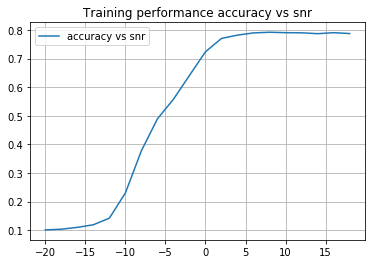

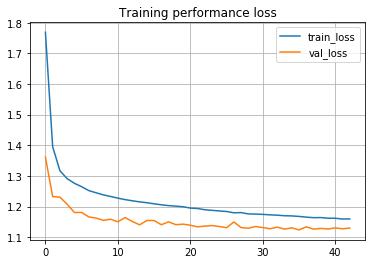

In [0]:
model_fit(model, X_train, Y_train, test_idx)


Train using integral data
Training shape:  (600000, 2, 128)
Labels shape:  (600000, 10)
Train on 570000 samples, validate on 30000 samples
Epoch 1/50
570000/570000 [==============================] - 14s 24us/sample - loss: 1.7889 - acc: 0.3002 - val_loss: 1.6353 - val_acc: 0.3378
Epoch 2/50
570000/570000 [==============================] - 14s 25us/sample - loss: 1.6585 - acc: 0.3329 - val_loss: 1.5991 - val_acc: 0.3588
Epoch 3/50
570000/570000 [==============================] - 14s 24us/sample - loss: 1.6320 - acc: 0.3428 - val_loss: 1.5866 - val_acc: 0.3596
Epoch 4/50
570000/570000 [==============================] - 14s 24us/sample - loss: 1.6133 - acc: 0.3500 - val_loss: 1.5601 - val_acc: 0.3705
Epoch 5/50
570000/570000 [==============================] - 14s 24us/sample - loss: 1.5929 - acc: 0.3612 - val_loss: 1.5287 - val_acc: 0.3858
Epoch 6/50
570000/570000 [==============================] - 14s 24us/sample - loss: 1.5730 - acc: 0.3712 - val_loss: 1.5122 - val_acc: 0.3963
Epoch 7/5

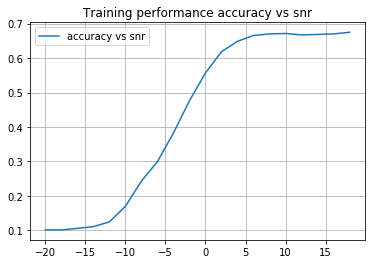

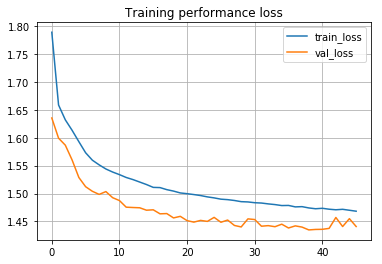

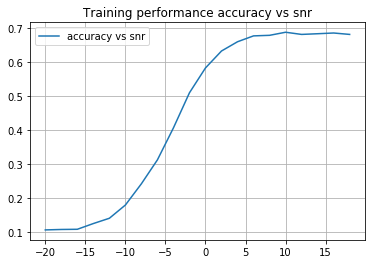

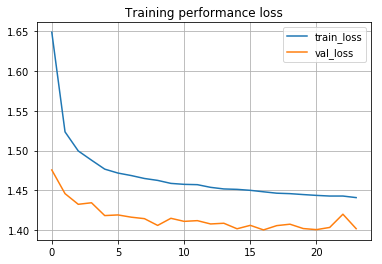

In [0]:
import pickle
from keras.models import load_model


# model.save('gdrive/My Drive/my_model.h5')
# del model

print("Train using integral data")
integral_data = pickle.load(open("gdrive/My Drive/integral.pickle","rb"))

X_train, X_test, Y_train, Y_test, test_idx = split(integral_data)
X_train, X_test = featureScaling(X_train, X_test)


# model = tf.keras.models.load_model('gdrive/My Drive/my_model.h5')

model_fit(model, X_train, Y_train, test_idx)


del integral_data

print("Train using differential data")


diff_data = pickle.load(open("gdrive/My Drive/diff.pickle","rb"))


X_train, X_test, Y_train, Y_test, test_idx = split(diff_data)
X_train, X_test = featureScaling(X_train, X_test)

model_fit(model, X_train, Y_train, test_idx)

del diff_data


In [0]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

in_shp [2, 128]


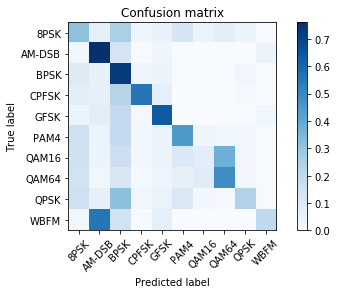

In [0]:
in_shp = list(X_train.shape[1:])
print("in_shp",in_shp)
classes = mods

batch_size = 10024

# Plot confusion matrix
#Return (600000, 10) matrix with the probabilities for each sample to be of labels 0-9
test_Y_hat = model.predict(X_test, batch_size=batch_size)

#Matrix initialization
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])


for i in range(0, X_test.shape[0]):
    #j is the true label for the sample
    j = list(Y_test[i,:]).index(1)
    #k is the predicted label for the sample with the highest probability
    k = int(np.argmax(test_Y_hat[i,:]))
    #Icrement the following cell in the confusion matrix
    conf[j,k] = conf[j,k] + 1

#Compute normalized confusion matrix
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

snr -20
Overall Accuracy:  0.10683989045487943
snr -18
Overall Accuracy:  0.10814512895897367
snr -16
Overall Accuracy:  0.10870796814076715
snr -14
Overall Accuracy:  0.12553996584402102
snr -12
Overall Accuracy:  0.1410453240771644
snr -10
Overall Accuracy:  0.17988607215430227
snr -8
Overall Accuracy:  0.2423256894434673
snr -6
Overall Accuracy:  0.31248956141229917
snr -4
Overall Accuracy:  0.40634370627040717
snr -2
Overall Accuracy:  0.5093126088704274
snr 0
Overall Accuracy:  0.5822338604089032
snr 2
Overall Accuracy:  0.6319241011984021
snr 4
Overall Accuracy:  0.6590735259884939
snr 6
Overall Accuracy:  0.676288318144159
snr 8
Overall Accuracy:  0.6779300959272413
snr 10
Overall Accuracy:  0.6869637512470901
snr 12
Overall Accuracy:  0.680580520604487
snr 14
Overall Accuracy:  0.6826007629789351
snr 16
Overall Accuracy:  0.6847249557994463
snr 18
Overall Accuracy:  0.680588530346096


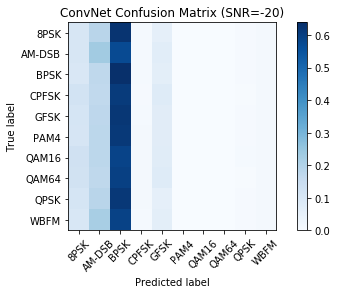

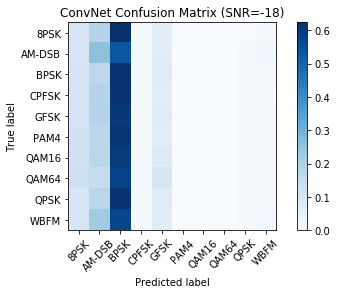

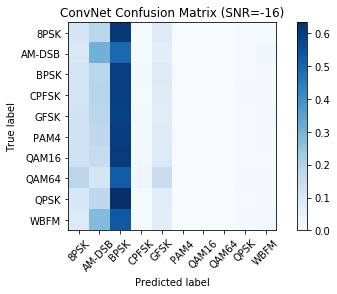

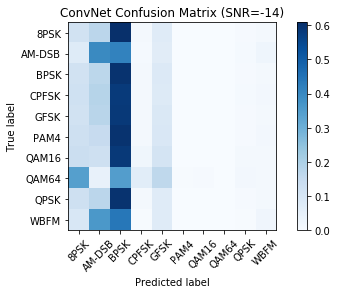

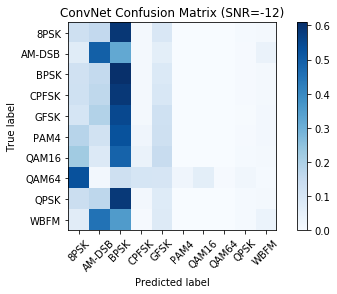

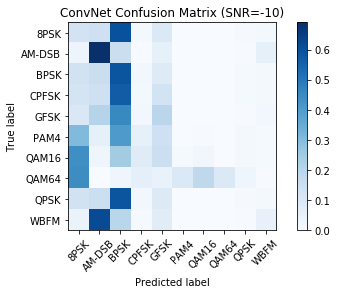

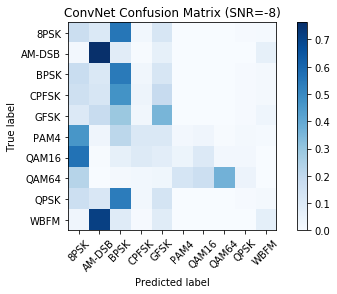

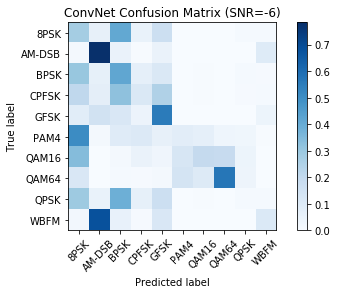

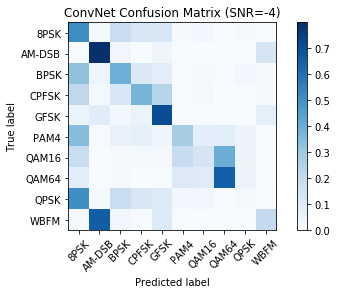

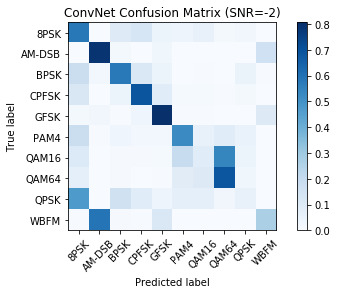

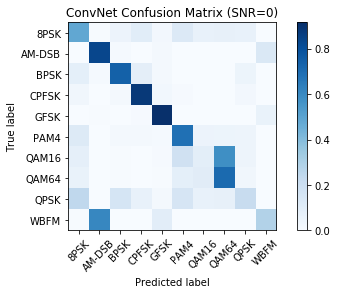

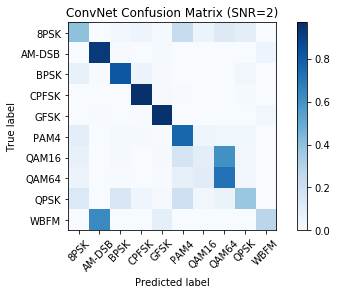

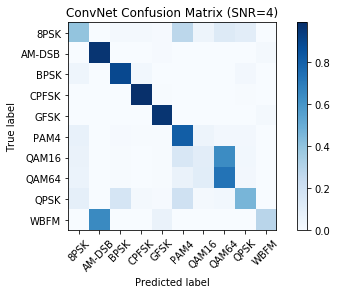

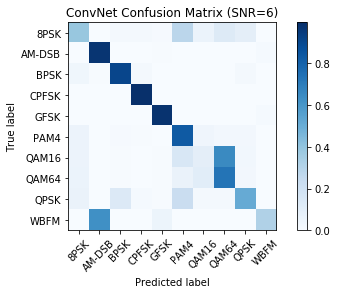

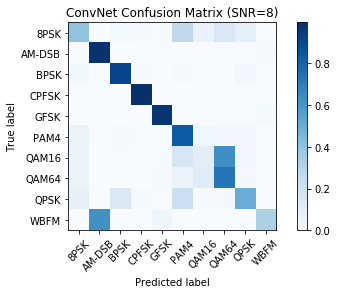

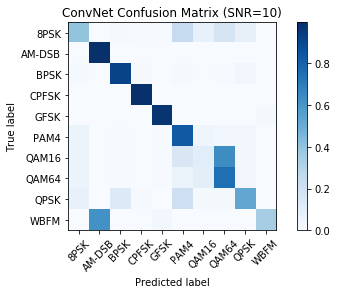

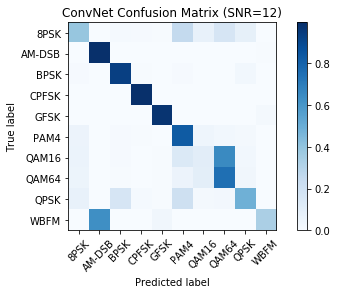

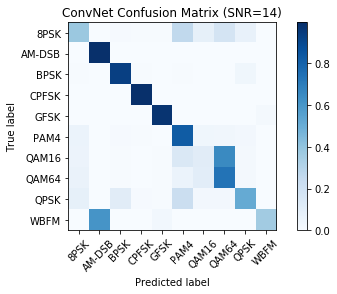

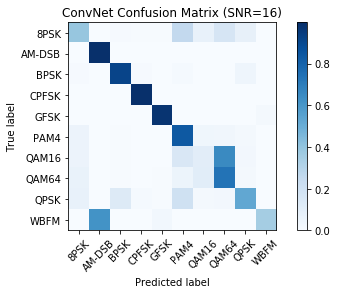

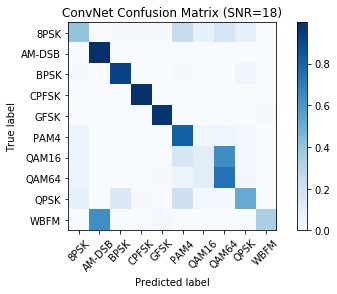

In [0]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor

    print("snr",snr)
    print ("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)